## Bases de Datos No Relacionales

### Tarea Final -  Red de virus de animales a través del Property Graph Model

Este notebook es parte del trabajo final del curso de Bases de Datos No Relacionales, InCo, FING, UdelaR.

Autores: Mikaela Lezcano y Felipe Maresca

#### Ambiente de ejecución

Opción 1: Instalación local
Para ejecutar este notebook en forma local es necesario instalar:
- Jupyter Notebook
- Python 3.8

Una de las formas más sencillas de gestionar todo esto es instalando Anaconda. Hay varios tutoriales disponibles, por ejemplo [este]( https://mediuh.com/codingthesmartway-com-blog/getting-started-with-jupyter-notebook-for-python-4e7082bd5d46)

Opción 2: Ejecución remota
Si no quieren instalar el ambiente en su máquina pueden subir este notebook y ejecutarlo en el ambiente [Colaboratory]( https://colab.research.google.com/) de Google

Acceso a Neo4j:
Además es necesario tener acceso a un servidor Neo4j. Algunas opciones son: 1) [instalarlo localmente en su PC](https://neo4j.com/download-center/#community), 2) usar [Neo4j Sandbox](https://neo4j.com/sandbox/) en la nube (cuidado que esta cuentas tiene una vigencia máxima de 10 días), o 3) crear una cuenta y usar [Neo4j AuraDB] (https://neo4j.com/pricing/) en la nube (la versión gratuita no tiene límite de tiempo). Si usan AuraDB creen una instancia vacía, no las que vienen precargadas.

Base de datos:
En todos los casos se va a utilizar la base de datos [VIRION](https://github.com/viralemergence/virion/tree/main/Virion). Tanto en la instalación local como en el Sandbox este proyecto se puede elegir e instalar, mientras que en el caso de AuraDS hay que importar los datos desde el siguiente [repositorio](https://github.com/FelipeMaresca/TrabajoFinalBDNR2023). No se puede utilizar AuraDB ya que no permite utilizar la librería Graph Data Science implementada en el presente trabajo.

La imagen a continuación muestra el esquema conceptual de la base de datos relacional VIRION.

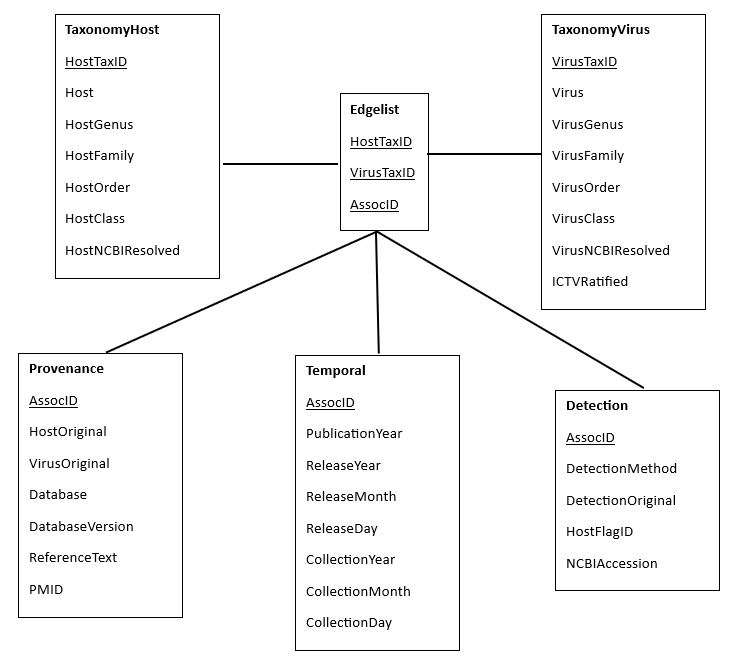

In [1]:
# CARGAR LIBRERIAS #

#%pip install numpy #version numpy-1.25.0
#%pip install pandas #version pandas-2.0.3
#%pip install matplotlib #version matplotlib-3.7.1
#%pip install scipy #version scipy-1.11.1

import random
import numpy as np
import scipy 
import pandas as pd
import matplotlib.pyplot as plt

#permite conectarse a la BD
#%pip install py2neo #version py2neo-2021.2.3
import py2neo
from py2neo import Graph, Node, Relationship

#permite representar gráficamente los grafos obtenidos
#%pip install neo4jupyter #version neo4jupyter-0.2.0
import neo4jupyter
neo4jupyter.init_notebook_mode()

print('py2neo version', py2neo.__version__)

<IPython.core.display.Javascript object>

py2neo version 2021.2.3


In [2]:
# CONEXIÓN A NEO4J Desktop #
# En caso de utilizar otra conexión, asegurarse de editar esta sección con la información correspondiente

host = "bolt://localhost:7687" #indica la url de la BD
user = "neo4j" #indica usuario y pass a la BD
password= "BDNRBDNR"

grafo = Graph(host, auth=(user, password))
#grafo.set_database("neo4j")
#print(gds.version())

In [3]:
# SEMILLA #

np.random.seed(1995)

In [4]:
# CANTIDAD DE NODOS Y DE VÍNCULOS #

nro_nodos_host="MATCH(h:Host) RETURN count(h)"
nro_nodos_virus="MATCH(v:Virus) RETURN count(v)"
vinculos_infecta="MATCH (h:Host)<-[:Infecta_a]-(v:Virus) RETURN count(v)"

#evaluamos las consultas
result_host=grafo.evaluate(nro_nodos_host) #4122 nodos tipo Host
result_virus=grafo.evaluate(nro_nodos_virus) #9753 nodos tipo Virus
result_infecta=grafo.evaluate(vinculos_infecta) #25403 vinculos tipo "Infecta_a"

#imprimo resultados
print(f'En la BD hay {result_host} nodos tipo Host y {result_virus} nodos tipo Virus')
print(f'En la BD hay {result_infecta} vinculos tipo "Infecta_a"')


En la BD hay 4122 nodos tipo Host y 9753 nodos tipo Virus
En la BD hay 25403 vinculos tipo "Infecta_a"


In [5]:
# NODOS ÚNICOS TIPO HOST #

nodos_host="MATCH(h:Host) RETURN DISTINCT h.Host"
#nodos_host="MATCH(h:Host) RETURN DISTINCT h.HostGenus, h.HostFamily, h.HostOrder, h.HostClass"
host = grafo.run(nodos_host).to_data_frame()
print(host)
print(len(host)) #Hay 3673 únicos y el paper dice 3692, 19 de diferencia

                         h.Host
0                 abramis brama
1          abrothrix longipilis
2           abrothrix olivaceus
3            abrothrix sanborni
4     acanthemblemaria crockeri
...                         ...
3668        zosterops japonicus
3669        zosterops lateralis
3670    zygodontomys brevicauda
3671      zygodontomys cherriei
3672                         NA

[3673 rows x 1 columns]
3673


In [6]:
# NODOS ÚNICOS TIPO VIRUS #

nodos_virus="MATCH(v:Virus) RETURN DISTINCT v.Virus"
virus = grafo.run(nodos_virus).to_data_frame()
print(virus)
print(len(virus)) #Hay 9518 únicos y el paper dice 9521, 3 de diferencia

                                         v.Virus
0                                    aalivirus a
1                        abatino macacapox virus
2                  abelson murine leukemia virus
3                                   academ virus
4           acanthis flammea cress-dna-virus sp.
...                                          ...
9513  zosterops erythropleurus genomoviridae sp.
9514     zuerich pelophylax collection ranavirus
9515                        zurich hartmanivirus
9516                    zwiesel bat banyangvirus
9517                                          NA

[9518 rows x 1 columns]
9518


In [7]:
# PROPIEDADES DE CADA TIPO DE NODO #

propiedades_nodos_host="MATCH(h:Host) RETURN keys(h) as Propiedades"
propiedades_nodos_virus="MATCH(v:Virus) RETURN keys(v) as Propiedades"

propiedades_h = grafo.run(propiedades_nodos_host)
propiedades_v = grafo.run(propiedades_nodos_virus)

print(propiedades_h)
print(propiedades_v)

 Propiedades                                                                                                                                                                                                                     
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 ['ID_mudularity', 'ID_labelprop', 'ID_weakly', 'degree', 'ID_louvain', 'ID_louvain_proj_h', 'articlerun_write', 'pagerank_write', 'HostOrder', 'Host', 'HostClass', 'HostFamily', 'HostGenus', 'HostTaxID', 'HostNCBIResolved'] 
 ['ID_mudularity', 'ID_weakly', 'ID_labelprop', 'ID_louvain_proj_h', 'articlerun_write', 'degree', 'Host', 'ID_louvain', 'HostOrder', 'pagerank_write', 'HostClass', 'HostFamily', 'HostGenus', 'HostTaxID', 'HostNCBIResolved'] 
 ['ID_mudularity', 'ID_weakly', 'ID_labelprop', 'ID_louvain_proj_h', 'articlerun_write', 'degree

In [8]:
# CANTIDAD DE NODOS POR especie/genero/familia/orden/clase PARA HOSPEDADORES Y VIRUS #

especies_h="MATCH(h:Host) WITH DISTINCT h.Host AS e RETURN count(e) AS Especies_host"
generos_h="MATCH(h:Host) WITH DISTINCT h.HostGenus AS g RETURN count(g) AS Géneros_host"
familias_h="MATCH(h:Host) WITH DISTINCT h.HostFamily AS f RETURN count(f) AS Familias_host"
ordenes_h="MATCH(h:Host) WITH DISTINCT h.HostOrder AS o RETURN count(o) AS Ordenes_host"
clases_h="MATCH(h:Host) WITH DISTINCT h.HostClass AS c RETURN count(c) AS Clases_host"
especies_h=grafo.evaluate(especies_h)
generos_h=grafo.evaluate(generos_h)
familias_h=grafo.evaluate(familias_h)
ordenes_h=grafo.evaluate(ordenes_h)
clases_h=grafo.evaluate(clases_h)

especies_v="MATCH(v:Virus) WITH DISTINCT v.Virus AS e RETURN count(e) AS Especies_virus"
generos_v="MATCH(v:Virus) WITH DISTINCT v.VirusGenus AS g RETURN count(g) AS Géneros_virus"
familias_v="MATCH(v:Virus) WITH DISTINCT v.VirusFamily AS f RETURN count(f) AS Familias_virus"
ordenes_v="MATCH(v:Virus) WITH DISTINCT v.VirusOrder AS o RETURN count(o) AS Ordenes_virus"
clases_v="MATCH(v:Virus) WITH DISTINCT v.VirusClass AS c RETURN count(c) AS Clases_virus"
especies_v=grafo.evaluate(especies_v)
generos_v=grafo.evaluate(generos_v)
familias_v=grafo.evaluate(familias_v)
ordenes_v=grafo.evaluate(ordenes_v)
clases_v=grafo.evaluate(clases_v)

print(f'En la BD hay {especies_h} especies, {generos_h} géneros, {familias_h} familias, {ordenes_h} ordenes y {clases_h} clases de hospedadores.')
print(f'En la BD hay {especies_v} especies, {generos_v} géneros, {familias_v} familias, {ordenes_v} ordenes y {clases_v} clases de virus.')
print("--------------------")
print(type(generos_h))

En la BD hay 3673 especies, 1774 géneros, 479 familias, 116 ordenes y 9 clases de hospedadores.
En la BD hay 9518 especies, 370 géneros, 67 familias, 36 ordenes y 27 clases de virus.
--------------------
<class 'int'>


In [9]:
# CANTIDAD DE NODOS POR CATEGORIA DE especie/genero/familia/orden/clase PARA HOSPEDADORES Y VIRUS #

categ_especies_h="MATCH(h:Host) RETURN h.Host AS Especies_host, count(h) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_generos_h="MATCH(h:Host) RETURN h.HostGenus AS Géneros_host, count(h) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_familias_h="MATCH(h:Host) RETURN h.HostFamily AS Familias_host, count(h) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_ordenes_h="MATCH(h:Host) RETURN h.HostOrder AS Ordenes_host, count(h) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_clases_h="MATCH(h:Host) RETURN h.HostClass AS Clases_host, count(h) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_especies_h=grafo.run(categ_especies_h).to_data_frame()
categ_generos_h=grafo.run(categ_generos_h).to_data_frame()
categ_familias_h=grafo.run(categ_familias_h).to_data_frame()
categ_ordenes_h=grafo.run(categ_ordenes_h).to_data_frame()
categ_clases_h=grafo.run(categ_clases_h).to_data_frame()

categ_especies_v="MATCH(v:Virus) RETURN v.Virus AS Especies_virus, count(v) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_generos_v="MATCH(v:Virus) RETURN v.VirusGenus AS Géneros_virus, count(v) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_familias_v="MATCH(v:Virus) RETURN v.VirusFamily AS Familias_virus, count(v) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_ordenes_v="MATCH(v:Virus) RETURN v.VirusOrder AS Ordenes_virus, count(v) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_clases_v="MATCH(v:Virus) RETURN v.VirusClass AS Clases_virus, count(v) AS Cantidad ORDER BY Cantidad DESC LIMIT 5"
categ_especies_v=grafo.run(categ_especies_v).to_data_frame()
categ_generos_v=grafo.run(categ_generos_v).to_data_frame()
categ_familias_v=grafo.run(categ_familias_v).to_data_frame()
categ_ordenes_v=grafo.run(categ_ordenes_v).to_data_frame()
categ_clases_v=grafo.run(categ_clases_v).to_data_frame()

#print(categ_especies_h)
#print("--------------------")
#print(categ_generos_h)
#print("--------------------")
#print(categ_familias_h)
#print("--------------------")
print(categ_ordenes_h)
print("--------------------")
print(categ_clases_h)
print("--------------------")
#print(categ_especies_v)
#print("--------------------")
#print(categ_generos_v)
#print("--------------------")
#print(categ_familias_v)
#print("--------------------")
print(categ_ordenes_v)
print("--------------------")
print(categ_clases_v)

    Ordenes_host  Cantidad
0       rodentia       517
1     chiroptera       438
2  passeriformes       393
3       primates       235
4   artiodactyla       232
--------------------
    Clases_host  Cantidad
0      mammalia      1841
1          aves      1207
2   actinopteri       660
3  lepidosauria       165
4      amphibia       162
--------------------
     Ordenes_virus  Cantidad
0   picornavirales      1162
1      nidovirales      1114
2  mononegavirales       857
3    herpesvirales       690
4               NA       676
--------------------
      Clases_virus  Cantidad
0  pisoniviricetes      2276
1   monjiviricetes       861
2   herviviricetes       690
3               NA       676
4   ellioviricetes       624


In [10]:
# PROPORCIONES EN CADA CATEGORÍA #

categ_especies_h['Proporción']=categ_especies_h['Cantidad'] / especies_h
categ_generos_h['Proporción']=categ_generos_h['Cantidad'] / especies_h
categ_familias_h['Proporción']=categ_familias_h['Cantidad'] / especies_h
categ_ordenes_h['Proporción']=categ_ordenes_h['Cantidad'] / especies_h
categ_clases_h['Proporción']=categ_clases_h['Cantidad'] / especies_h
categ_especies_v['Proporción']=categ_especies_v['Cantidad'] / especies_v
categ_generos_v['Proporción']=categ_generos_v['Cantidad'] / especies_v
categ_familias_v['Proporción']=categ_familias_v['Cantidad'] / especies_v
categ_ordenes_v['Proporción']=categ_ordenes_v['Cantidad'] / especies_v
categ_clases_v['Proporción']=categ_clases_v['Cantidad'] / especies_v
#print(categ_especies_h)
#print("--------------------")
#print(categ_generos_h)
#print("--------------------")
#print(categ_familias_h)
#print("--------------------")
print(categ_ordenes_h)
print("--------------------")
print(categ_clases_h)
print("--------------------")
#print(categ_especies_v)
#print("--------------------")
#print(categ_generos_v)
#print("--------------------")
#print(categ_familias_v)
#print("--------------------")
print(categ_ordenes_v)
print("--------------------")
print(categ_clases_v)

    Ordenes_host  Cantidad  Proporción
0       rodentia       517    0.140757
1     chiroptera       438    0.119249
2  passeriformes       393    0.106997
3       primates       235    0.063980
4   artiodactyla       232    0.063164
--------------------
    Clases_host  Cantidad  Proporción
0      mammalia      1841    0.501225
1          aves      1207    0.328614
2   actinopteri       660    0.179690
3  lepidosauria       165    0.044922
4      amphibia       162    0.044106
--------------------
     Ordenes_virus  Cantidad  Proporción
0   picornavirales      1162    0.122084
1      nidovirales      1114    0.117041
2  mononegavirales       857    0.090040
3    herpesvirales       690    0.072494
4               NA       676    0.071023
--------------------
      Clases_virus  Cantidad  Proporción
0  pisoniviricetes      2276    0.239126
1   monjiviricetes       861    0.090460
2   herviviricetes       690    0.072494
3               NA       676    0.071023
4   ellioviricetes      

vClass          alsuviricetes  arfiviricetes  chrymotiviricetes  \
hClass                                                            
actinopteri              26.0           14.0               12.0   
amphibia                  6.0            2.0                0.0   
aves                    276.0          272.0               16.0   
chondrichthyes            2.0            0.0                0.0   
hyperoartia               1.0            0.0                0.0   
lepidosauria             12.0            2.0                0.0   
mammalia                568.0          442.0                3.0   
myxini                    1.0            0.0                0.0   

vClass          chunqiuviricetes  duplopiviricetes  ellioviricetes  \
hClass                                                               
actinopteri                  1.0               1.0            17.0   
amphibia                     0.0               0.0             1.0   
aves                         0.0              20.

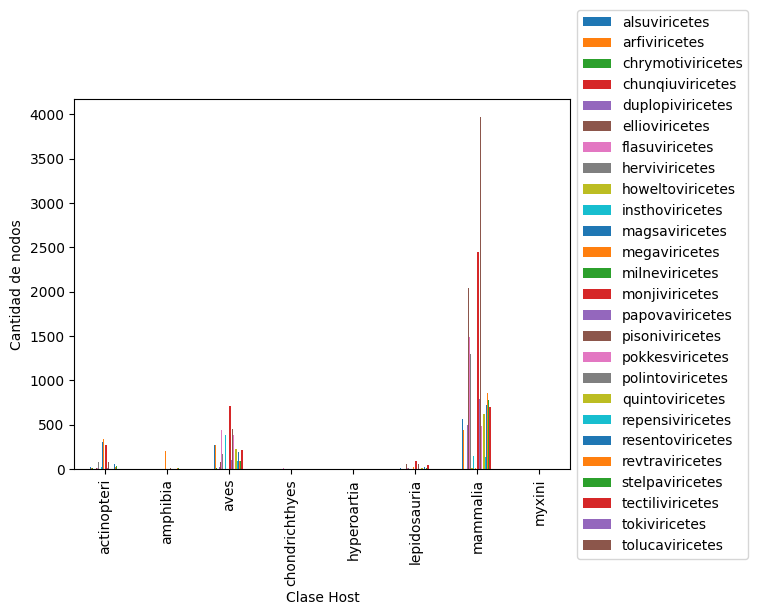

In [11]:
# TABLA DE RECUENTOS ENTRE CLASES (NIVEL MÁS MACRO) DE HOST-VIRUS version Host #

query="""
MATCH (h:Host)<-[:Infecta_a]-(v:Virus)
WITH h.HostClass AS hClass, v.VirusClass AS vClass, COUNT(*) AS conteo
RETURN hClass, vClass, conteo
"""

tabla1=grafo.run(query).to_data_frame()
df = tabla1.pivot(index='hClass', columns='vClass', values='conteo')
df = df.fillna(0)
columns_to_remove = ['NA']
rows_to_remove = ['NA']
df=df.drop(rows_to_remove)
df=df.drop(columns=columns_to_remove)
print(df)

df.plot.bar()
plt.xlabel('Clase Host')
plt.ylabel('Cantidad de nodos')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

hClass             actinopteri  amphibia   aves  chondrichthyes  hyperoartia  \
vClass                                                                         
alsuviricetes             26.0       6.0  276.0             2.0          1.0   
arfiviricetes             14.0       2.0  272.0             0.0          0.0   
chrymotiviricetes         12.0       0.0   16.0             0.0          0.0   
chunqiuviricetes           1.0       0.0    0.0             0.0          0.0   
duplopiviricetes           1.0       0.0   20.0             0.0          0.0   
ellioviricetes            17.0       1.0   85.0             1.0          0.0   
flasuviricetes             7.0       1.0  445.0            12.0          0.0   
herviviricetes            76.0       6.0  165.0             0.0          0.0   
howeltoviricetes           0.0       0.0    0.0             0.0          0.0   
insthoviricetes           29.0       2.0  384.0             2.0          0.0   
magsaviricetes           300.0       0.0

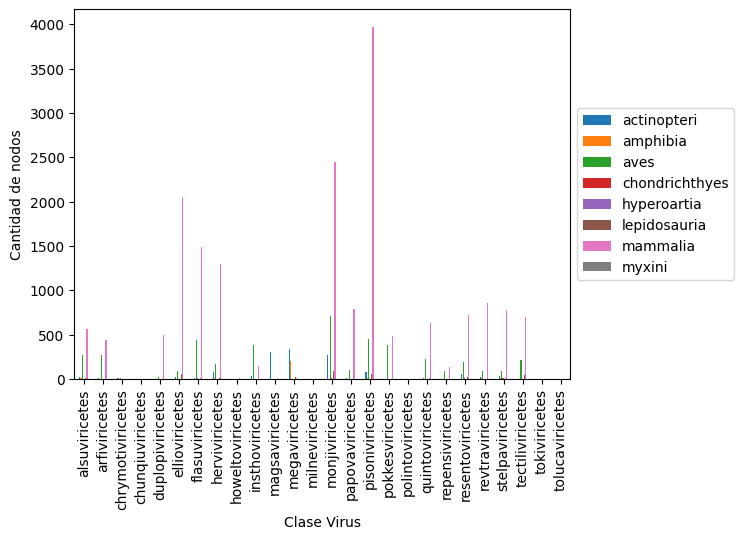

In [12]:
# TABLA DE RECUENTOS ENTRE CLASES (NIVEL MÁS MACRO) DE HOST-VIRUS version Virus #

query="""
MATCH (h:Host)<-[:Infecta_a]-(v:Virus)
WITH h.HostClass AS hClass, v.VirusClass AS vClass, COUNT(*) AS conteo
RETURN hClass, vClass, conteo
"""

tabla2=grafo.run(query).to_data_frame()
df = tabla2.pivot(index='vClass', columns='hClass', values='conteo')
df = df.fillna(0)
columns_to_remove = ['NA']
rows_to_remove = ['NA']
df=df.drop(rows_to_remove)
df=df.drop(columns=columns_to_remove)
print(df)

df.plot.bar()
plt.xlabel('Clase Virus')
plt.ylabel('Cantidad de nodos')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

vClass       NA  alsuviricetes  arfiviricetes  chrymotiviricetes  \
hClass                                                             
aves      324.0          275.0          272.0               16.0   
mammalia  437.0          566.0          441.0                3.0   

vClass    duplopiviricetes  ellioviricetes  flasuviricetes  herviviricetes  \
hClass                                                                       
aves                  20.0            85.0           415.0           165.0   
mammalia             488.0          1840.0          1265.0          1240.0   

vClass    howeltoviricetes  insthoviricetes  ...  pokkesviricetes  \
hClass                                       ...                    
aves                   0.0            382.0  ...            372.0   
mammalia              10.0            134.0  ...            446.0   

vClass    polintoviricetes  quintoviricetes  repensiviricetes  \
hClass                                                          
aves   

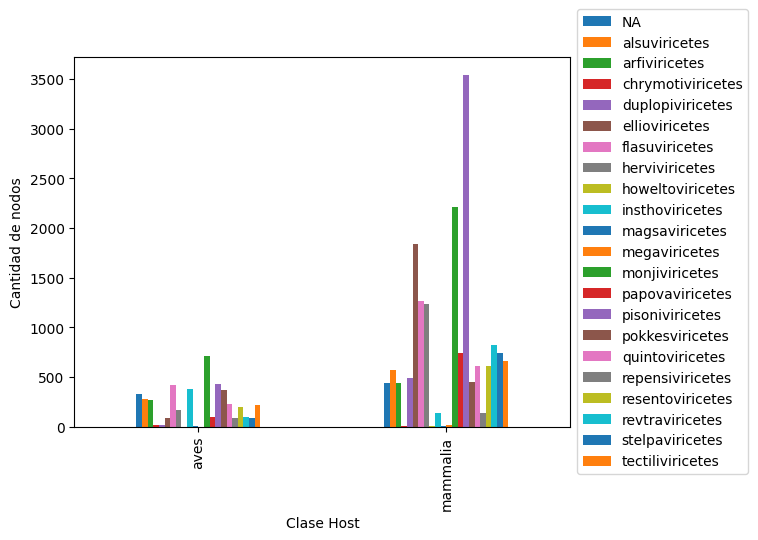

In [13]:
# TABLA DE RECUENTOS ENTRE CLASES (NIVEL MÁS MACRO) DE HOST-VIRUS #
# Se mantienen solo los host clase mamiferos y aves

query="""
MATCH (h:Host)<-[:Infecta_a]-(v:Virus)
WHERE h.HostClass IN ['mammalia', 'aves'] AND v.Virus <> 'NA'
WITH h.HostClass AS hClass, v.VirusClass AS vClass, COUNT(*) AS conteo
RETURN hClass, vClass, conteo
"""

tabla3=grafo.run(query).to_data_frame()
df = tabla3.pivot(index='hClass', columns='vClass', values='conteo')
df = df.fillna(0)
columns_to_remove = ['NA']
df.columns[df.sum() < 5]
df1=df.drop(columns=columns_to_remove)
df1=df.drop(columns=df.columns[df.sum() < 5])
print(df)

df1.plot.bar()
plt.xlabel('Clase Host')
plt.ylabel('Cantidad de nodos')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
# CUANTOS VIRUS INFECTAN A LOS HUMANOS Y A OTRO HOSPEDADOR NO MAMÍFERO #
# Para saber si solo hay que buscar dentro de los virus que infectan a los mamiferos
# (en pos de calcular el riesgo zoonotico)

q="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)-[:Infecta_a]->(b:Host)
    WHERE h.Host='homo sapiens' AND b.HostClass <> 'mammalia'
    RETURN count(DISTINCT v)"""
print(grafo.run(q).to_data_frame())

q2="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)
    WHERE h.Host='homo sapiens'
    RETURN count(v)"""
print(grafo.run(q2).to_data_frame())

### Un 9 % de los virus que infectan a los humanos no infectan a otros mamiferos,
### por lo que no tiene sentido filtrar por un grupo en particular la consulta de abajo

print(126/1410)

   count(DISTINCT v)
0                128
   count(v)
0      1415
0.08936170212765958


In [15]:
# RIESGO ZOONÓTICO #

### La consulta matchea todos los virus v que infectan a humanos, encuentra otros hosts b que son infectados por el mismo v,
### y encuentra los virus m que infectan a b pero no a los humanos (AND NOT EXISTS). Ahi cuento los distintos b para cada m,
### o sea cuantos hosts de m son infectados por un v que infecta a los humanos y lo denomino indice zoonotico (es medio sarasa pero tampoco taaan bolazo)
### me devuelve todos los m distintos, su info y su indice zoonotico

query="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)-[:Infecta_a]->(b:Host)<-[:Infecta_a]-(m:Virus)
    WHERE h.Host='homo sapiens' AND NOT EXISTS((m)-[:Infecta_a|Infectado_por]->(h))
    WITH m, count (DISTINCT b) AS index
    RETURN DISTINCT m.Virus AS especie_de_riesgo,m.VirusGenus AS Genus ,m.VirusFamily AS Family, m.VirusOrder AS Order,m.VirusClass AS Class, index
    ORDER BY index DESC"""
df=grafo.run(query).to_data_frame()
print(df)

#df.groupby('Genus')['index'].agg(['count', 'mean'])

#print(df['Family'].value_counts())
#print(df['Genus'].value_counts())
#print(df['Order'].value_counts())
#print(df['Class'].value_counts())

query2="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)-[:Infecta_a]->(b:Host)<-[:Infecta_a]-(m:Virus)
    WHERE h.Host='homo sapiens' AND b.HostClass='mammalia' AND NOT EXISTS((m)-[:Infecta_a|Infectado_por]->(h))
    WITH m, count (DISTINCT b) AS index
    RETURN DISTINCT m.Virus AS especie_de_riesgo,m.VirusGenus AS Genus ,m.VirusFamily AS Family, m.VirusOrder AS Order,m.VirusClass AS Class, index
    ORDER BY index DESC"""
df=grafo.run(query2).to_data_frame()
print(df)

query3="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)-[:Infecta_a]->(b:Host)<-[:Infecta_a]-(m:Virus)
    WHERE h.Host='homo sapiens' AND b.HostOrder='primates' AND NOT EXISTS((m)-[:Infecta_a|Infectado_por]->(h))
    WITH m, count (DISTINCT b) AS index
    RETURN DISTINCT m.Virus AS especie_de_riesgo, m.VirusGenus AS Genus, m.VirusFamily AS Family, m.VirusOrder AS Order, m.VirusClass AS Class, index
    ORDER BY index DESC"""
df=grafo.run(query3).to_data_frame()
print(df)

###Por ejemplo, la primer especie de riesgo (alphacoronavirus NA) infecta a 131 hosts que son infectados por algun virus que infecta al humano

                       especie_de_riesgo             Genus          Family  \
0                                     NA  alphacoronavirus   coronaviridae   
1                       bluetongue virus         orbivirus      reoviridae   
2                        bat coronavirus                NA   coronaviridae   
3            carnivore protoparvovirus 1   protoparvovirus    parvoviridae   
4                                     NA         orbivirus      reoviridae   
...                                  ...               ...             ...   
7056  rhinolophus sinicus polyomavirus 1                NA  polyomaviridae   
7057    bat sars-like coronavirus rs4092                NA   coronaviridae   
7058    bat sars-like coronavirus rs4110                NA   coronaviridae   
7059    bat sars-like coronavirus rs4084                NA   coronaviridae   
7060    bat sars-like coronavirus rs4085                NA   coronaviridae   

              Order             Class  index  
0       nidovira

In [16]:
# MEDIDAS DE CENTRALIDAD MICRO - DISTRIBUCIÓN DE GRADO Y GRADO MEDIO #

grado_host="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)
WITH h, count(v) AS Grado
RETURN Grado, h.Host AS ESPECIE_Host
ORDER BY Grado DESC"""
grado_host=grafo.run(grado_host).to_data_frame()
grado_uno_h = (grado_host['Grado'] == 1).sum()
print("Cantidad de nodos con grado 1:", grado_uno_h)
grado_medio_h=grado_host['Grado'].mean()
print(f'Grado medio de los nodos tipo host: {grado_medio_h}')
print(grado_host)

grado_virus="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)
WITH v, count(h) AS Grado
RETURN Grado, v.Virus AS ESPECIE_Virus
ORDER BY Grado DESC"""
grado_virus=grafo.run(grado_virus).to_data_frame()
grado_uno_v = (grado_virus['Grado'] == 1).sum()
print("Cantidad de nodos con grado 1:", grado_uno_v)
grado_medio_v=grado_virus['Grado'].mean()
print(f'Grado medio de los nodos tipo virus: {grado_medio_v}')
print(grado_virus)

Cantidad de nodos con grado 1: 1785
Grado medio de los nodos tipo host: 6.162785055798156
      Grado    ESPECIE_Host
0      1415    homo sapiens
1       573  macaca mulatta
2       416      sus scrofa
3       384      bos taurus
4       320   gallus gallus
...     ...             ...
4117      1              NA
4118      1              NA
4119      1              NA
4120      1              NA
4121      1              NA

[4122 rows x 2 columns]


Cantidad de nodos con grado 1: 8067
Grado medio de los nodos tipo virus: 2.6046344714446836
      Grado                           ESPECIE_Virus
0       465                       influenza a virus
1       308                 avian orthoavulavirus 1
2       283                         west nile virus
3       279                       rabies lyssavirus
4       215                                      NA
...     ...                                     ...
9748      1   macaca mulatta papillomavirus otufa53
9749      1  macaca mulatta papillomavirus otufa368
9750      1         macaca mulatta papillomavirus 6
9751      1                    rhesus adenovirus 61
9752      1           picobirnavirus predict_pbv-86

[9753 rows x 2 columns]


Cantidad de nodos con grado 1: 1639
Grado medio de los nodos tipo host: 5.903110377098816
   Grado    ESPECIE_Host
0   1389    homo sapiens
1    564  macaca mulatta
2    391      sus scrofa
3    357      bos taurus
4    317   gallus gallus


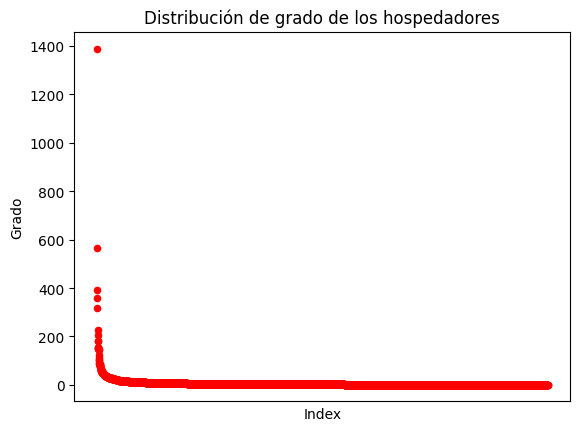

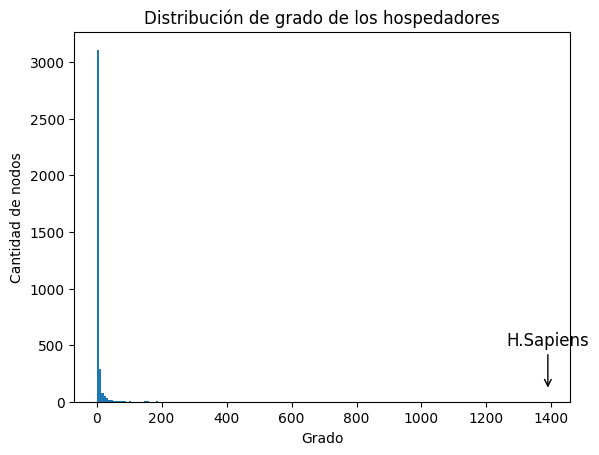

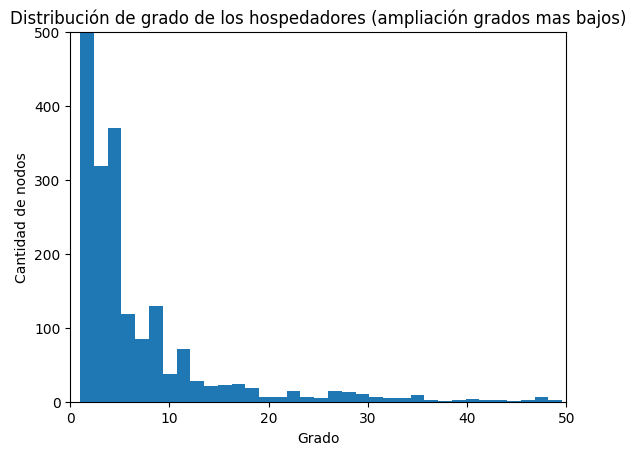

In [17]:
# MEDIDAS DE CENTRALIDAD MICRO - DISTRIBUCIÓN DE GRADO Y GRADO MEDIO #
# Se remueven especies no identificadas que inflan los nodos con grado 1

grado_host="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)
WHERE h.Host <> 'NA' AND v.Virus <> 'NA'
WITH h, count(v) AS Grado
RETURN Grado, h.Host AS ESPECIE_Host
ORDER BY Grado DESC"""

grado_host=grafo.run(grado_host).to_data_frame()
grado_uno_h = (grado_host['Grado'] == 1).sum()
print("Cantidad de nodos con grado 1:", grado_uno_h)

grado_medio_h=grado_host['Grado'].mean()
print(f'Grado medio de los nodos tipo host: {grado_medio_h}')

print(grado_host.head())

grado_host['Index'] = grado_host.index
grado_host=grado_host.astype({'Grado':'int'})

grado_host.plot.scatter(x='Index', y='Grado', color='red')
plt.xticks([])
plt.title('Distribución de grado de los hospedadores')
plt.show()

grado_host['Grado'].plot.hist(bins=200)
arrow_x = 1389
arrow_y = 100  
arrow_text = 'H.Sapiens'
arrow_props = {
    'facecolor': 'red',
    'arrowstyle': '->'
}
plt.annotate(arrow_text, xy=(arrow_x, arrow_y), xytext=(arrow_x, arrow_y + 400),
              arrowprops=arrow_props, fontsize=12, ha='center')
plt.title('Distribución de grado de los hospedadores')
plt.xlabel('Grado')
plt.ylabel('Cantidad de nodos')
plt.show()

grado_host['Grado'].plot.hist(bins=1000)
plt.title('Distribución de grado de los hospedadores (ampliación grados mas bajos)')
plt.xlabel('Grado')
plt.ylabel('Cantidad de nodos')
plt.xlim(0,50)
plt.ylim(0,500)
plt.show()

Cantidad de nodos con grado 1: 7798
Grado medio de los nodos tipo virus: 2.3354023739518674
   Grado                      ESPECIE_Virus
0    390                  influenza a virus
1    256            avian orthoavulavirus 1
2    246                    west nile virus
3    230                  rabies lyssavirus
4    136  eastern equine encephalitis virus


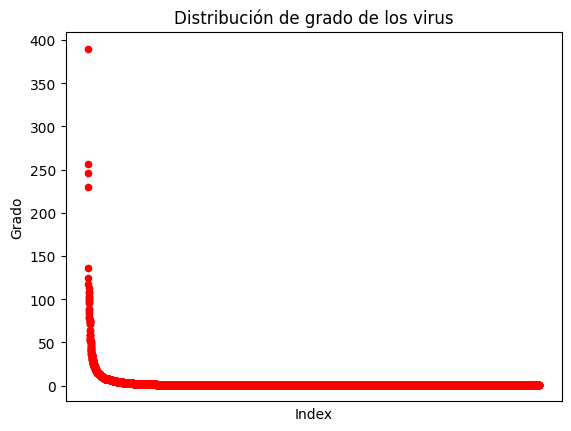

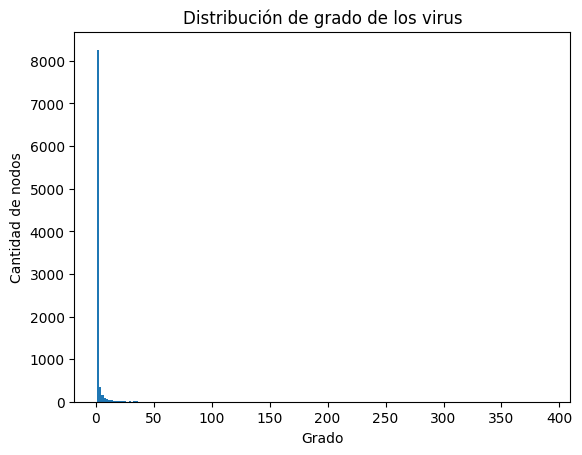

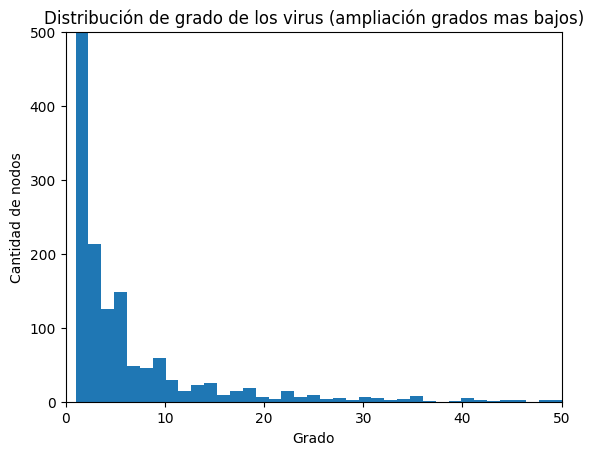

In [18]:
# MEDIDAS DE CENTRALIDAD MICRO - DISTRIBUCIÓN DE GRADO Y GRADO MEDIO #
# Se remueven especies no identificadas que inflan los nodos con grado 1

grado_virus="""MATCH (h:Host)<-[:Infecta_a]-(v:Virus)
WHERE h.Host <> 'NA' AND v.Virus <> 'NA'
WITH v, count(v) AS Grado
RETURN Grado, v.Virus AS ESPECIE_Virus
ORDER BY Grado DESC"""

grado_virus=grafo.run(grado_virus).to_data_frame()
grado_uno_v = (grado_virus['Grado'] == 1).sum()
print("Cantidad de nodos con grado 1:", grado_uno_v)

grado_medio_v=grado_virus['Grado'].mean()
print(f'Grado medio de los nodos tipo virus: {grado_medio_v}')

print(grado_virus.head())

grado_virus['Index'] = grado_virus.index 
grado_virus=grado_virus.astype({'Grado':'int'})
grado_virus.plot.scatter(x='Index', y='Grado', color='red')
plt.xticks([])
plt.title('Distribución de grado de los virus')
plt.show()

grado_virus['Grado'].plot.hist(bins=200)
plt.title('Distribución de grado de los virus')
plt.xlabel('Grado')
plt.ylabel('Cantidad de nodos')
plt.show()

grado_virus['Grado'].plot.hist(bins=300)
plt.ylim(0, 500)
plt.xlim(0, 50)
plt.title('Distribución de grado de los virus (ampliación grados mas bajos)')
plt.xlabel('Grado')
plt.ylabel('Cantidad de nodos')
plt.show()

In [19]:
# MEDIDAS DE CENTRALIDAD MACRO - DENSIDAD #

effective="""MATCH p = (:Host)<-[:Infecta_a]-(:Virus)
             RETURN count(p) AS effective """
possible= """MATCH (h:Host)
             MATCH (v:Virus)
             RETURN count(h)*count(v) AS Possible"""

effective_links=(grafo.evaluate(effective))
possible_links=(grafo.evaluate(possible))
densidad=effective_links/possible_links
print(f'La densidad de la red es: {densidad}')

La densidad de la red es: 1.5717829914997925e-11


In [24]:
# LISTAR EL CATÁLOGO DE LOS GRAFOS #

catalogo=("CALL gds.graph.list()")
grafo.run(catalogo).to_data_frame()

""


In [25]:
# BORRAR REDES DEL CATÁLOGO #

#catalogo=("CALL gds.graph.drop('RED1')")
#grafo.run(catalogo).to_data_frame()
#catalogo=("CALL gds.graph.drop('RED2')")
#grafo.run(catalogo).to_data_frame()

In [26]:
# CREAR RED 1 DENTRO DEL CATALOGO #

# A native projection takes three mandatory arguments: graphName, nodeProjection and relationshipProjection.
# graphName: The name under which the graph is stored in the catalog.
# nodeProjection: One or more node projections (especifica qué nodos de la base de datos deben proyectarse 
# en el grafo GDS en memoria. La proyección se basa en etiquetas de nodos).
# relationshipProjection: One or more relationship projections (La proyección de relaciones especifica 
# qué relaciones de la base de datos deben proyectarse en el grafo GDS en memoria.).


red1=(
    "CALL gds.graph.project('RED1', ['Host', 'Virus'], {relType: {type: 'Infecta_a', orientation: 'UNDIRECTED', properties: {} } } )"
    )

proyeccion1=grafo.run(red1).to_data_frame()
print(red1)

CALL gds.graph.project('RED1', ['Host', 'Virus'], {relType: {type: 'Infecta_a', orientation: 'UNDIRECTED', properties: {} } } )


In [27]:
# CREAR RED 2 DENTRO DEL CATALOGO #

red2=(
    "CALL gds.graph.project('RED2', ['Host', 'Virus'], {relType: {type: 'Infecta_a', orientation: 'NATURAL', properties: {} } } )"
    )

proyeccion2=grafo.run(red2).to_data_frame()
print(red2)

CALL gds.graph.project('RED2', ['Host', 'Virus'], {relType: {type: 'Infecta_a', orientation: 'NATURAL', properties: {} } } )


In [28]:
# CENTRALIDAD PAGERANK MODALIDAD WRITE #

# El algoritmo PageRank mide la importancia de cada nodo dentro del grafo, 
# en función del número de relaciones entrantes y la importancia de los nodos 
# de origen correspondientes. La suposición subyacente, en términos generales, 
# es que una página es tan importante como las páginas que la vinculan.

np.random.seed(1995)

pagerank_write="""CALL gds.pageRank.write('RED1', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'pagerank_write'
})"""

pagerank_write=grafo.run(pagerank_write)
print(pagerank_write)

#host
ver_pagerank_write="""MATCH (h:Host)
RETURN h.HostTaxID AS HostTaxID,  h.Host AS Especie, h.pagerank_write AS pagerank_write
ORDER BY pagerank_write DESC LIMIT 5"""

ver_pagerank_write=grafo.run(ver_pagerank_write)
print(ver_pagerank_write)

#virus
ver_pagerank_write="""MATCH (v:Virus)
RETURN v.VirusTaxID AS VirusTaxID, v.Virus AS Especie, v.pagerank_write AS pagerank_write
ORDER BY pagerank_write DESC LIMIT 5"""

ver_pagerank_write=grafo.run(ver_pagerank_write)
print(ver_pagerank_write)

 writeMillis | nodePropertiesWritten | ranIterations | didConverge | centralityDistribution                                                                                                                                                                                                          | postProcessingMillis | preProcessingMillis | computeMillis | configuration                                                                                                                                                                                                                                                                                 
-------------|-----------------------|---------------|-------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------|---------------------|---------------|--

In [29]:
# CENTRALIDAD ARTICLE RANK MODALIDAD WRITE #

# ArticleRank es una variante del algoritmo Page Rank, que mide la influencia transitiva de los nodos.
# Page Rank sigue la suposición de que las relaciones que se originan en los nodos de bajo grado tienen 
# una mayor influencia que las relaciones de los nodos de alto grado. Article Rank reduce la influencia 
# de los nodos de bajo grado al reducir las puntuaciones que se envían a sus vecinos en cada iteración.

np.random.seed(1995)

articlerun_write="""CALL gds.articleRank.write('RED1', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'articlerun_write'
})"""

articlerun_write=grafo.run(articlerun_write)
print(articlerun_write)

#host
ver_articlerun_write="""MATCH (h:Host)
RETURN h.HostTaxID AS HostTaxID, h.Host AS Especie, h.articlerun_write AS articlerun_write
ORDER BY articlerun_write DESC LIMIT 5"""

ver_articlerun_write=grafo.run(ver_articlerun_write)
print(ver_articlerun_write)

#virus
ver_articlerun_write="""MATCH (v:Virus)
RETURN v.VirusTaxID AS VirusTaxID, v.Virus AS Especie, v.articlerun_write AS articlerun_write
ORDER BY articlerun_write DESC LIMIT 5"""

ver_articlerun_write=grafo.run(ver_articlerun_write)
print(ver_articlerun_write)

 writeMillis | nodePropertiesWritten | ranIterations | didConverge | centralityDistribution                                                                                                                                                                                                               | postProcessingMillis | preProcessingMillis | computeMillis | configuration                                                                                                                                                                                                                                                                                   
-------------|-----------------------|---------------|-------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------|---------------------|------

In [30]:
# CENTRALIDAD DE GRADO MODALIDAD WRITE (en ejemplo de documentación cuenta nodos de entrada nomás) #
# Mismos resultados que los obtenidos anteriormente sin filtrar los nodos con NA es Especie.

np.random.seed(1995)

# El algoritmo de centralidad de grado se puede utilizar para encontrar nodos 
# populares dentro de un grafo. La centralidad de grado mide el número de 
# relaciones entrantes o salientes (o ambas) de un nodo, según la orientación 
# de una proyección de relación.

centgrado_write="""CALL gds.degree.write('RED1', { writeProperty: 'degree' })
YIELD centralityDistribution, nodePropertiesWritten
RETURN centralityDistribution.min AS minimumScore, 
centralityDistribution.mean AS meanScore, nodePropertiesWritten"""

centgrado_write=grafo.run(centgrado_write)
print(centgrado_write)

#host
ver_centgrado_write="""MATCH (h:Host)
RETURN h.HostTaxID AS HostTaxID, h.Host AS Especie, h.degree AS degree
ORDER BY degree DESC LIMIT 5"""

ver_centgrado_write=grafo.run(ver_centgrado_write)
print(ver_centgrado_write)

#virus
ver_centgrado_write="""MATCH (v:Virus)
RETURN v.VirusTaxID AS VirusTaxID, v.Virus AS Especie, v.degree AS degree
ORDER BY degree DESC LIMIT 5"""

ver_centgrado_write=grafo.run(ver_centgrado_write)
print(ver_centgrado_write)

 minimumScore |         meanScore | nodePropertiesWritten 
--------------|-------------------|-----------------------
          1.0 | 3.661702246863563 |                 13875 

 HostTaxID | Especie        | degree 
-----------|----------------|--------
 9606      | homo sapiens   | 1415.0 
 9544      | macaca mulatta |  573.0 
 9823      | sus scrofa     |  416.0 

 VirusTaxID | Especie                 | degree 
------------|-------------------------|--------
 11320      | influenza a virus       |  465.0 
 2560319    | avian orthoavulavirus 1 |  308.0 
 11082      | west nile virus         |  283.0 



In [31]:
# LISTAR EL CATÁLOGO DE LOS GRAFOS #

grafo.run(catalogo).to_data_frame()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'p99': 25, 'min': 0, 'max': 465, 'mean': 1.83...",RED2,neo4j,2979 KiB,3050608,13875,25403,{'relationshipProjection': {'relType': {'orien...,0.000132,2023-07-08T21:10:01.518982199,2023-07-08T21:10:01.575011100-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."
1,"{'p99': 44, 'min': 1, 'max': 1415, 'mean': 3.6...",RED1,neo4j,4003 KiB,4099400,13875,50806,{'relationshipProjection': {'relType': {'orien...,0.000264,2023-07-08T21:09:58.402195000-03:00,2023-07-08T21:09:58.531658600-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."


In [32]:
# DETECCIÓN DE COMUNIDADES CON ALGORITMO Louvain MODALIDAD WRITE #

# Directed and Undirected graphs
# Maximiza una puntuación de modularidad para cada comunidad, donde la modularidad cuantifica la calidad 
# de una asignación de nodos a las comunidades. Esto significa evaluar qué tan densamente conectados están 
# los nodos dentro de una comunidad, en comparación con qué tan conectados estarían en una red aleatoria.
# El algoritmo de Louvain es un algoritmo de agrupamiento jerárquico que fusiona recursivamente 
# comunidades en un solo nodo y ejecuta el agrupamiento de modularidad en los grafos condensados.

np.random.seed(1995)

comus_louvain_w =( '''
    CALL gds.louvain.write('RED1', { writeProperty: 'ID_louvain' })
    YIELD communityCount, modularity, modularities, communityDistribution
  '''
)

comus_louvain_w = grafo.run(comus_louvain_w)
print(comus_louvain_w)

np.random.seed(1995)

comus_louvain2_w =( '''
    CALL gds.louvain.write('RED2', { writeProperty: 'ID_louvain2' })
    YIELD communityCount, modularity, modularities, communityDistribution
  '''
)

comus_louvain2_w = grafo.run(comus_louvain2_w)
print(comus_louvain2_w)

 communityCount |         modularity | modularities                                                                   | communityDistribution                                                                                
----------------|--------------------|--------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------
            439 | 0.7421737027220252 | [0.561683701482951, 0.7249485000992751, 0.739514372177523, 0.7421737027220252] | {p99: 926, min: 2, max: 1906, mean: 31.605922551252846, p90: 6, p50: 2, p999: 1906, p95: 53, p75: 3} 

 communityCount |          modularity | modularities                                                                                                                                                                                                     | communityDistribution                                                             

In [33]:
# DETECCIÓN DE COMUNIDADES CON ALGORITMO Label Propagation MODALIDAD WRITE #

# Directed and Undirected graphs
# Detecta comunidades utilizando únicamente la estructura de la red como guía y no requiere 
# una función objetivo predefinida o información previa sobre las comunidades.
# LPA funciona propagando etiquetas a través de la red y formando comunidades basadas en este 
# proceso de propagación de etiquetas.
# La intuición detrás del algoritmo es que una sola etiqueta puede convertirse rápidamente en 
# dominante en un grupo de nodos densamente conectados, pero tendrá problemas para cruzar una 
# región escasamente conectada.

np.random.seed(1995)

comus_labelprop_w =( '''
    CALL gds.labelPropagation.write('RED1', { writeProperty: 'ID_labelprop' })
    YIELD communityCount, nodePropertiesWritten, communityDistribution
  '''
)

comus_labelprop_w = grafo.run(comus_labelprop_w)
print(comus_labelprop_w)

np.random.seed(1995)

comus_labelprop2_w =( '''
    CALL gds.labelPropagation.write('RED1', { writeProperty: 'ID_labelprop2' })
    YIELD communityCount, nodePropertiesWritten, communityDistribution
  '''
)

comus_labelprop2_w = grafo.run(comus_labelprop2_w)
print(comus_labelprop2_w)

 communityCount | nodePropertiesWritten | communityDistribution                                                                                 
----------------|-----------------------|-------------------------------------------------------------------------------------------------------
            771 |                 13875 | {p99: 302, min: 1, max: 3079, mean: 17.996108949416342, p90: 20, p50: 3, p999: 3079, p95: 57, p75: 7} 

 communityCount | nodePropertiesWritten | communityDistribution                                                                                 
----------------|-----------------------|-------------------------------------------------------------------------------------------------------
            771 |                 13875 | {p99: 302, min: 1, max: 3079, mean: 17.996108949416342, p90: 20, p50: 3, p999: 3079, p95: 57, p75: 7} 



In [34]:
# CHEQUEAR PROPIEDADES DE NODO1 TIPO HOST #

#propiedades_nodo_h1="""MATCH (h:Host)
#WHERE id(h) = 1
#RETURN properties(h) AS Propiedades"""
#propiedades_nodo_h1 = grafo.run(propiedades_nodo_h1)
#print(propiedades_nodo_h1)

In [35]:
# CONDUCTANCIA PARA COMPARAR LOS MÉTODOS DE DETECCIÓN DE COMUNIDADES #

#conduct_labelprop="""CALL gds.alpha.conductance.stream('RED1', { communityProperty: 'ID_labelprop'})
#YIELD community, conductance"""

#conduct_labelprop = grafo.run(conduct_labelprop)
#print(conduct_labelprop)

In [36]:
# MODULARIDAD PARA COMPARAR LOS MÉTODOS DE DETECCIÓN DE COMUNIDADES #

#modularidad_labelprop="""CALL gds.alpha.modularity.stream('RED1', { communityProperty: 'ID_labelprop'})
#YIELD communityId, modularity
#RETURN communityId, modularity
#ORDER BY modularity DESC"""

#modularidad_labelprop="""CALL gds.alpha.modularity.stats('RED1', { communityProperty: 'ID_labelprop'})
#YIELD communityCount, modularity"""

#modularidad_labelprop = grafo.run(modularidad_labelprop)
#print(modularidad_labelprop)

In [37]:
# DETECCIÓN DE COMUNIDADES CON ALGORITMO Weakly Connected Components MODALIDAD WRITE #

# Directed and Undirected graphs
# Dos nodos están conectados, si existe un camino entre ellos. El conjunto de todos los nodos que están 
# conectados entre sí forman un componente. A diferencia de los componentes fuertemente conectados (SCC), 
# no se considera la dirección de las relaciones en la ruta entre dos nodos. 

np.random.seed(1995)

comus_weakly_w =( '''
    CALL gds.wcc.write('RED1', { writeProperty: 'ID_weakly' })
    YIELD componentCount, nodePropertiesWritten, componentDistribution
  '''
)

comus_weakly_w = grafo.run(comus_weakly_w)
print(comus_weakly_w)

np.random.seed(1995)

comus_weakly2_w =( '''
    CALL gds.wcc.write('RED1', { writeProperty: 'ID_weakly2' })
    YIELD componentCount, nodePropertiesWritten, componentDistribution
  '''
)

comus_weakly2_w = grafo.run(comus_weakly2_w)
print(comus_weakly2_w)

 componentCount | nodePropertiesWritten | componentDistribution                                                                               
----------------|-----------------------|-----------------------------------------------------------------------------------------------------
            409 |                 13875 | {p99: 9, min: 2, max: 12781, mean: 33.924205378973106, p90: 4, p50: 2, p999: 12781, p95: 5, p75: 3} 

 componentCount | nodePropertiesWritten | componentDistribution                                                                               
----------------|-----------------------|-----------------------------------------------------------------------------------------------------
            409 |                 13875 | {p99: 9, min: 2, max: 12781, mean: 33.924205378973106, p90: 4, p50: 2, p999: 12781, p95: 5, p75: 3} 



In [38]:
# DETECCIÓN DE COMUNIDADES CON ALGORITMO Modularity Optimization MODALIDAD WRITE #

# Directed and Undirected graphs
# Intenta detectar comunidades en el grafo en función de su modularidad. La modularidad es una medida 
# de la estructura de un grafo, midiendo la densidad de conexiones dentro de un módulo o comunidad. 
# Los grafos con una puntuación de modularidad alta tendrán muchas conexiones dentro de una comunidad, 
# pero solo unas pocas apuntarán hacia otras comunidades. El algoritmo explorará para cada nodo si su 
# puntaje de modularidad podría aumentar si cambia su comunidad a uno de sus nodos vecinos.

np.random.seed(1995)

comus_mudularity_w =( '''
    CALL gds.beta.modularityOptimization.write('RED1', { writeProperty: 'ID_mudularity' })
    YIELD communityCount, modularity, communityDistribution
  '''
)

comus_mudularity_w = grafo.run(comus_mudularity_w)
print(comus_mudularity_w)

np.random.seed(1995)

comus_mudularity2_w =( '''
    CALL gds.beta.modularityOptimization.write('RED1', { writeProperty: 'ID_mudularity2' })
    YIELD communityCount, modularity, communityDistribution
  '''
)

comus_mudularity2_w = grafo.run(comus_mudularity2_w)
print(comus_mudularity2_w)

 communityCount |         modularity | communityDistribution                                                                             
----------------|--------------------|---------------------------------------------------------------------------------------------------
           1742 | 0.5612646137725208 | {p99: 73, min: 2, max: 959, mean: 7.964982778415615, p90: 11, p50: 3, p999: 480, p95: 21, p75: 5} 

 communityCount |         modularity | communityDistribution                                                                             
----------------|--------------------|---------------------------------------------------------------------------------------------------
           1740 | 0.5613664473946293 | {p99: 76, min: 2, max: 959, mean: 7.974137931034483, p90: 11, p50: 3, p999: 480, p95: 21, p75: 5} 



In [39]:
# ELIMINAR PROPIEDADES RELACIONADAS A DETECCION DE COMUNIDADES CON RED2 (se usará RED1) #

borrar1="""MATCH (h:Host)
REMOVE  h.ID_louvain2, h.ID_labelprop2, h.ID_weakly2, h.ID_mudularity2"""
borrar1 = grafo.run(borrar1)

borrar2="""MATCH (v:Virus)
REMOVE  v.ID_louvain2, v.ID_labelprop2, v.ID_weakly2, v.ID_mudularity2"""
borrar2 = grafo.run(borrar2)

In [40]:
# PROPIEDADES DE CADA TIPO DE NODO #

propiedades_nodos_host="MATCH(h:Host) RETURN keys(h) as Propiedades"
propiedades_nodos_virus="MATCH(v:Virus) RETURN keys(v) as Propiedades"

propiedades_h = grafo.run(propiedades_nodos_host)
propiedades_v = grafo.run(propiedades_nodos_virus)

print(propiedades_h)
print(propiedades_v)

 Propiedades                                                                                                                                                                                                                     
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 ['ID_mudularity', 'ID_labelprop', 'ID_weakly', 'degree', 'ID_louvain', 'ID_louvain_proj_h', 'articlerun_write', 'pagerank_write', 'HostOrder', 'Host', 'HostClass', 'HostFamily', 'HostGenus', 'HostTaxID', 'HostNCBIResolved'] 
 ['ID_mudularity', 'ID_weakly', 'ID_labelprop', 'ID_louvain_proj_h', 'articlerun_write', 'degree', 'Host', 'ID_louvain', 'HostOrder', 'pagerank_write', 'HostClass', 'HostFamily', 'HostGenus', 'HostTaxID', 'HostNCBIResolved'] 
 ['ID_mudularity', 'ID_weakly', 'ID_labelprop', 'ID_louvain_proj_h', 'articlerun_write', 'degree

In [41]:
# VER LAS COMUNIDADES CON ID_louvain #

q="""MATCH (h:Host)
    WITH h.ID_louvain AS ComunidadID, COUNT(*) AS ConteoHost
    RETURN ComunidadID, ConteoHost
    ORDER BY ConteoHost DESC"""
top_five_louvain_h=grafo.run(q).to_data_frame().head(5)
print(top_five_louvain_h) #top 5 de comunidades con mas nodos host

q="""MATCH (v:Virus)
    WITH v.ID_louvain AS ComunidadID, COUNT(*) AS ConteoVirus
    RETURN ComunidadID, ConteoVirus
    ORDER BY ConteoVirus DESC"""
top_five_louvain_v=grafo.run(q).to_data_frame().head(5)
print(top_five_louvain_v) #top 5 de comunidades con mas nodos virus

q="""MATCH (n)
    WITH n.ID_louvain AS ComunidadID, COUNT(*) AS ConteoGral
    RETURN ComunidadID, ConteoGral
    ORDER BY ConteoGral DESC"""
top_five_louvain_GRAL=grafo.run(q).to_data_frame().head(5)
print(top_five_louvain_GRAL)  #top 5 de comunidades con mas nodos en general

   ComunidadID  ConteoHost
0         4687         745
1         7661         486
2         5919         446
3        13445         263
4         9348         260
   ComunidadID  ConteoVirus
0        13445         1643
1         4167          973
2         4687          861
3         4300          689
4         8281          687
   ComunidadID  ConteoGral
0        13445        1906
1         4687        1606
2         4167         990
3         8281         936
4         4300         926


In [42]:
# CLASES DE HOST PRESENTES EN LAS 5 COMUNIDADES CON MAS NODOS HOST #
#El 100% de la clase es la cantidad de nodos Host, es como si no estuvieran los Virus

top_five_conteos_h={}

for i in range(len(top_five_louvain_h)):
    com_id=top_five_louvain_h.loc[i, 'ComunidadID']
    com_id = int(com_id)

    q="""MATCH (h:Host)
    WHERE h.ID_louvain=$com_id
    WITH h.HostClass AS Clase, COUNT(*) as Conteo
    RETURN Clase, Conteo
    ORDER BY Conteo DESC"""
    params = {"com_id": com_id}
    df_top_five = grafo.run(q, params).to_data_frame()
    total_comunidad=df_top_five['Conteo'].sum()
    df_top_five['Proporcion']=(df_top_five['Conteo']/total_comunidad)

    top_five_conteos_h[i]=df_top_five

print(top_five_conteos_h[0])
print(top_five_conteos_h[1])
#print(top_five_conteos_h[2])
#print(top_five_conteos_h[3])
#print(top_five_conteos_h[4])

            Clase  Conteo  Proporcion
0            aves     693    0.930201
1        mammalia      32    0.042953
2              NA       9    0.012081
3    lepidosauria       6    0.008054
4  chondrichthyes       3    0.004027
5     actinopteri       2    0.002685
            Clase  Conteo  Proporcion
0     actinopteri     478    0.983539
1  chondrichthyes       5    0.010288
2     hyperoartia       2    0.004115
3        amphibia       1    0.002058


In [43]:
print(top_five_conteos_h[2])
print(top_five_conteos_h[3])
print(top_five_conteos_h[4])

          Clase  Conteo  Proporcion
0      mammalia     291    0.652466
1          aves     144    0.322870
2  lepidosauria       9    0.020179
3            NA       2    0.004484
      Clase  Conteo  Proporcion
0  mammalia     259    0.984791
1      aves       4    0.015209
          Clase  Conteo  Proporcion
0      mammalia     248    0.953846
1   actinopteri       5    0.019231
2  lepidosauria       3    0.011538
3          aves       3    0.011538
4      amphibia       1    0.003846


In [48]:
# CLASES DE VIRUS PRESENTES EN LAS 5 COMUNIDADES CON MAS NODOS VIRUS #
#El 100% de la clase es la cantidad de nodos Virus, es como si no estuvieran los Host

top_five_conteos_v={}

for i in range(len(top_five_louvain_v)):
    com_id=top_five_louvain_v.loc[i, 'ComunidadID']
    com_id = int(com_id)

    q="""MATCH (v:Virus)
    WHERE v.ID_louvain=$com_id
    WITH v.VirusClass AS Clase, COUNT(*) as Conteo
    RETURN Clase, Conteo
    ORDER BY Conteo DESC"""
    params = {"com_id": com_id}
    df_top_five = grafo.run(q, params).to_data_frame()
    total_comunidad=df_top_five['Conteo'].sum()
    df_top_five['Proporcion']=(df_top_five['Conteo']/total_comunidad)

    top_five_conteos_v[i]=df_top_five

print(top_five_conteos_v[0].head())
print(top_five_conteos_v[1].head())
#print(top_five_conteos_v[2].head())
#print(top_five_conteos_v[3].head())
#print(top_five_conteos_v[4].head())

              Clase  Conteo  Proporcion
0   pisoniviricetes     671    0.408399
1   stelpaviricetes     261    0.158856
2    monjiviricetes     210    0.127815
3  tectiliviricetes      87    0.052952
4   quintoviricetes      83    0.050517
             Clase  Conteo  Proporcion
0  pisoniviricetes     486    0.499486
1               NA      96    0.098664
2  papovaviricetes      87    0.089414
3   ellioviricetes      74    0.076053
4    arfiviricetes      74    0.076053


In [49]:
print(top_five_conteos_v[2].head())
print(top_five_conteos_v[3].head())
print(top_five_conteos_v[4].head())

              Clase  Conteo  Proporcion
0   pisoniviricetes     148    0.171893
1   pokkesviricetes     112    0.130081
2  resentoviricetes      93    0.108014
3   quintoviricetes      90    0.104530
4     arfiviricetes      73    0.084785
             Clase  Conteo  Proporcion
0  pisoniviricetes     124    0.179971
1   herviviricetes      95    0.137881
2  papovaviricetes      71    0.103048
3    arfiviricetes      57    0.082729
4   monjiviricetes      35    0.050798
             Clase  Conteo  Proporcion
0   ellioviricetes     150    0.218341
1  pisoniviricetes     148    0.215429
2   monjiviricetes      76    0.110626
3   herviviricetes      63    0.091703
4   flasuviricetes      37    0.053857


In [53]:
# CLASES DE HOST Y VIRUS PRESENTES EN LAS 5 COMUNIDADES CON MAS NODOS #

top_five_conteos_GRAL={}

for i in range(len(top_five_louvain_GRAL)):
    com_id=top_five_louvain_GRAL.loc[i, 'ComunidadID']
    com_id = int(com_id)

    q="""MATCH (n)
    WHERE n.ID_louvain=$com_id
    WITH n.HostClass AS HostClase, n.VirusClass AS VirusClase, COUNT(*) as Conteo
    RETURN HostClase, VirusClase, Conteo
    ORDER BY Conteo DESC"""
    params = {"com_id": com_id}
    df_top_five = grafo.run(q, params).to_data_frame()
    total_comunidad=df_top_five['Conteo'].sum()
    df_top_five['Proporcion']=(df_top_five['Conteo']/total_comunidad)
    top_five_conteos_GRAL[i]=df_top_five

print(top_five_conteos_GRAL[0].head(8))
#print(top_five_conteos_GRAL[1].head(8))
#print(top_five_conteos_GRAL[2].head(8))
#print(top_five_conteos_GRAL[3].head(8))
#print(top_five_conteos_GRAL[4].head(8))

  HostClase        VirusClase  Conteo  Proporcion
0      None   pisoniviricetes     671    0.352046
1      None   stelpaviricetes     261    0.136936
2  mammalia              None     259    0.135887
3      None    monjiviricetes     210    0.110178
4      None  tectiliviricetes      87    0.045645
5      None   quintoviricetes      83    0.043547
6      None   papovaviricetes      78    0.040923
7      None    herviviricetes      69    0.036201


In [54]:
print(top_five_conteos_GRAL[1].head(8))

  HostClase        VirusClase  Conteo  Proporcion
0      aves              None     693    0.431507
1      None   pisoniviricetes     148    0.092154
2      None   pokkesviricetes     112    0.069738
3      None  resentoviricetes      93    0.057908
4      None   quintoviricetes      90    0.056040
5      None     arfiviricetes      73    0.045455
6      None                NA      60    0.037360
7      None  tectiliviricetes      43    0.026775


In [55]:
print(top_five_conteos_GRAL[2].head(8))

  HostClase        VirusClase  Conteo  Proporcion
0      None   pisoniviricetes     486    0.490909
1      None                NA      96    0.096970
2      None   papovaviricetes      87    0.087879
3      None    ellioviricetes      74    0.074747
4      None     arfiviricetes      74    0.074747
5      None  tectiliviricetes      37    0.037374
6      None  resentoviricetes      22    0.022222
7      None   stelpaviricetes      20    0.020202


In [56]:
print(top_five_conteos_GRAL[3].head(8))

  HostClase        VirusClase  Conteo  Proporcion
0  mammalia              None     221    0.236111
1      None    ellioviricetes     150    0.160256
2      None   pisoniviricetes     148    0.158120
3      None    monjiviricetes      76    0.081197
4      None    herviviricetes      63    0.067308
5      None    flasuviricetes      37    0.039530
6      None  tectiliviricetes      36    0.038462
7      None   stelpaviricetes      32    0.034188


In [57]:
print(top_five_conteos_GRAL[4].head(8))

  HostClase        VirusClase  Conteo  Proporcion
0  mammalia              None     224    0.241901
1      None   pisoniviricetes     124    0.133909
2      None    herviviricetes      95    0.102592
3      None   papovaviricetes      71    0.076674
4      None     arfiviricetes      57    0.061555
5      None    monjiviricetes      35    0.037797
6      None    ellioviricetes      35    0.037797
7      None  resentoviricetes      31    0.033477


In [59]:
# PROPORCIONES DE CADA ASOCIACION EN RELACIÓN A TODA LA BASE #

###Para saber si las comunidades estan detectando agrupamientos estructurados taxonomicamente
###y no por otras causas se debe comparar las proporciones con las que hay en toda la red. 

q="""MATCH (n)
    WITH n.HostClass AS HostClase, n.VirusClass AS VirusClase, COUNT(*) as Conteo
    RETURN HostClase, VirusClase, Conteo
    ORDER BY Conteo DESC"""
conteos_total=grafo.run(q).to_data_frame()
total=conteos_total['Conteo'].sum()
print(total) #13875 en total
conteos_total['Proporcion']=(conteos_total['Conteo']/total)
print(conteos_total)

13875
         HostClase         VirusClase  Conteo  Proporcion
0             None    pisoniviricetes    2276    0.164036
1         mammalia               None    1841    0.132685
2             aves               None    1207    0.086991
3             None     monjiviricetes     861    0.062054
4             None     herviviricetes     690    0.049730
5             None                 NA     676    0.048721
6      actinopteri               None     660    0.047568
7             None     ellioviricetes     624    0.044973
8             None    papovaviricetes     596    0.042955
9             None    stelpaviricetes     560    0.040360
10            None   tectiliviricetes     526    0.037910
11            None    quintoviricetes     514    0.037045
12            None   duplopiviricetes     471    0.033946
13            None      arfiviricetes     422    0.030414
14            None    pokkesviricetes     256    0.018450
15            None   resentoviricetes     245    0.017658
16      

In [61]:
# DATAFRAME CON PROPORCIONES POR ASOCIACION EN EL TOTAL DE LA BASE Y POR COMUNIDAD #

df_proporciones = pd.merge(conteos_total[['HostClase', 'VirusClase', 'Conteo','Proporcion']],
                            top_five_conteos_GRAL[0][['HostClase', 'VirusClase', 'Conteo','Proporcion']], on=['HostClase', 'VirusClase'], how='outer', suffixes=('_total', '_comunidad1')).merge(
                             top_five_conteos_GRAL[1][['HostClase', 'VirusClase','Conteo', 'Proporcion']], on=['HostClase', 'VirusClase'], how='outer', suffixes=('', '_comunidad2')).merge(
                              top_five_conteos_GRAL[2][['HostClase', 'VirusClase', 'Conteo','Proporcion']], on=['HostClase', 'VirusClase'], how='outer', suffixes=('', '_comunidad3')).merge(
                               top_five_conteos_GRAL[3][['HostClase', 'VirusClase','Conteo', 'Proporcion']], on=['HostClase', 'VirusClase'], how='outer', suffixes=('', '_comunidad4')).merge(
                                top_five_conteos_GRAL[4][['HostClase', 'VirusClase', 'Conteo','Proporcion']], on=['HostClase', 'VirusClase'], how='outer', suffixes=('', '_comunidad5'))


df_proporciones.fillna(0, inplace=True)

print(df_proporciones.head(5))
print(df_proporciones.shape)

  HostClase       VirusClase  Conteo_total  Proporcion_total  \
0         0  pisoniviricetes          2276          0.164036   
1  mammalia                0          1841          0.132685   
2      aves                0          1207          0.086991   
3         0   monjiviricetes           861          0.062054   
4         0   herviviricetes           690          0.049730   

   Conteo_comunidad1  Proporcion_comunidad1  Conteo  Proporcion  \
0              671.0               0.352046   148.0    0.092154   
1              259.0               0.135887    32.0    0.019925   
2                4.0               0.002099   693.0    0.431507   
3              210.0               0.110178    37.0    0.023039   
4               69.0               0.036201    29.0    0.018057   

   Conteo_comunidad3  Proporcion_comunidad3  Conteo_comunidad4  \
0              486.0               0.490909              148.0   
1               13.0               0.013131              221.0   
2             

In [62]:
# TEST CHI-CUADRADO PARA LA COMUNIDAD 1 (la mas abudante) #

total_counts = df_proporciones['Conteo_comunidad1'].sum()
expected_counts = df_proporciones['Proporcion_total'] * total_counts

observed_counts = df_proporciones['Conteo_comunidad1'].values
contingency_table = np.vstack((observed_counts, expected_counts)).T

chi2, p_value, dof, expected = scipy.stats.chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square: 794.0688556477277
p-value: 3.4398337577760463e-144
Degrees of freedom: 35


In [63]:
# TEST CHI-CUADRADO PARA LA COMUNIDAD 2 #

total_counts = df_proporciones['Conteo'].sum()
expected_counts = df_proporciones['Proporcion_total'] * total_counts

observed_counts = df_proporciones['Conteo'].values
contingency_table = np.vstack((observed_counts, expected_counts)).T

chi2, p_value, dof, expected = scipy.stats.chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square: 916.587213222584
p-value: 9.072456487256035e-170
Degrees of freedom: 35


In [64]:
# TEST CHI-CUADRADO PARA LA COMUNIDAD 3 #

total_counts = df_proporciones['Conteo_comunidad3'].sum()
expected_counts = df_proporciones['Proporcion_total'] * total_counts

observed_counts = df_proporciones['Conteo_comunidad3'].values
contingency_table = np.vstack((observed_counts, expected_counts)).T

chi2, p_value, dof, expected = scipy.stats.chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square: 606.685198262407
p-value: 2.0111124921783817e-105
Degrees of freedom: 35


In [65]:
# TEST CHI-CUADRADO PARA LA COMUNIDAD 4 #

total_counts = df_proporciones['Conteo_comunidad4'].sum()
expected_counts = df_proporciones['Proporcion_total'] * total_counts

observed_counts = df_proporciones['Conteo_comunidad4'].values
contingency_table = np.vstack((observed_counts, expected_counts)).T

chi2, p_value, dof, expected = scipy.stats.chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square: 269.3787311894933
p-value: 5.790978464886441e-38
Degrees of freedom: 35


In [66]:
# TEST CHI-CUADRADO PARA LA COMUNIDAD 5 #

total_counts = df_proporciones['Conteo_comunidad5'].sum()
expected_counts = df_proporciones['Proporcion_total'] * total_counts

observed_counts = df_proporciones['Conteo_comunidad5'].values
contingency_table = np.vstack((observed_counts, expected_counts)).T

chi2, p_value, dof, expected = scipy.stats.chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_value)
print("Degrees of freedom:", dof)

Chi-square: 245.39469978448778
p-value: 2.03445108542264e-33
Degrees of freedom: 35


In [66]:
# PROYECCION DE LA RED BIPARTITA PARA LOS HOST (puede demorar unos minutos) #

q = """
MATCH (h1:Host)<-[:Infecta_a]-(v:Virus)-[:Infecta_a]->(h2:Host)
WHERE NOT EXISTS((h1)-[:SHARES_V]->(h2)) AND NOT EXISTS((h1)<-[:SHARES_V]-(h2)) AND h1.HostTaxID > h2.HostTaxID
WITH h1, h2, v
LIMIT 20000
MERGE (h1)-[r:SHARES_V]->(h2)
RETURN count(r) AS createdCount
"""
batch_size = 20000

while True:
    result = grafo.run(q).to_data_frame()
    created_count = result["createdCount"].iloc[0]
    print(f"{created_count} relationships created in the current batch.")

    if created_count < batch_size:
            break # Break the loop when there are no more relationships to process

20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.


In [67]:
# PROYECCION DE LA RED BIPARTITA PARA LOS VIRUS (puede demorar alrededor de 30-40 minutos) #

q = """
MATCH (v1:Virus)-[:Infecta_a]->(h:Host)<-[:Infecta_a]-(v2:Virus)
WHERE NOT EXISTS((v1)-[:SHARES_H]->(v2)) AND NOT EXISTS((v1)<-[:SHARES_H]-(v2)) AND v1.VirusTaxID > v2.VirusTaxID
WITH v1, v2, h
LIMIT 20000
MERGE (v1)-[r:SHARES_H]->(v2)
RETURN count(r) AS createdCount
"""
batch_size = 20000

while True:
    result = grafo.run(q).to_data_frame()
    created_count = result["createdCount"].iloc[0]
    print(f"{created_count} relationships created in the current batch.")

    if created_count < batch_size:
            break # Break the loop when there are no more relationships to process

20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.
20000 relationships created in the current batch.


In [67]:
# CANTIDAD DE VINCULOS EN LAS REDES PROYECTADAS #

vinculos_h="MATCH (h1:Host)<-[:SHARES_V]-(h2:Host) RETURN count(h1)"
vinculos_h=grafo.evaluate(vinculos_h) #413.915 vinculos entre host
print(f'En la BD hay {vinculos_h} vinculos entre nodos Host')

vinculos_v="MATCH (v1:Virus)<-[:SHARES_H]-(v2:Virus) RETURN count(v1)"
vinculos_v=grafo.evaluate(vinculos_v) #1.676.298 vinculos entre virus
print(f'En la BD hay {vinculos_v} vinculos entre nodos Virus')

En la BD hay 413915 vinculos entre nodos Host


En la BD hay 1676298 vinculos entre nodos Virus


In [68]:
# CREAR RED PROY DE HOST DENTRO DEL CATALOGO #

red_proj_host=(
        '''CALL gds.graph.project(
            'RED_proj_Host', ['Host'],               
    {relType: {type: 'SHARES_V', orientation: 'UNDIRECTED', properties: {} } } )
    
    '''
    )

proyeccion=grafo.run(red_proj_host).to_data_frame()
print(red_proj_host)

CALL gds.graph.project(
            'RED_proj_Host', ['Host'],               
    {relType: {type: 'SHARES_V', orientation: 'UNDIRECTED', properties: {} } } )
    
    


In [69]:
# LISTAR CATALOGO #

q=("CALL gds.graph.list()")
grafo.run(q).to_data_frame()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'p99': 25, 'min': 0, 'max': 465, 'mean': 1.83...",RED2,neo4j,2979 KiB,3050768,13875,25403,{'relationshipProjection': {'relType': {'orien...,0.000132,2023-07-08T21:10:01.518982199,2023-07-08T21:10:01.575011100-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."
1,"{'p99': 44, 'min': 1, 'max': 1415, 'mean': 3.6...",RED1,neo4j,4003 KiB,4099432,13875,50806,{'relationshipProjection': {'relType': {'orien...,0.000264,2023-07-08T21:09:58.402195000-03:00,2023-07-08T21:09:58.531658600-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."
2,"{'p99': 1035, 'min': 0, 'max': 2494, 'mean': 2...",RED_proj_Host,neo4j,1440 KiB,1475280,4122,827830,{'relationshipProjection': {'relType': {'orien...,0.048734,2023-07-08T21:19:51.174704400-03:00,2023-07-08T21:19:51.306525600-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."


In [70]:
# DETECCION DE COMUNIDADES CON LOUVAIN Y LA RED PROY DE HOST #

np.random.seed(1995)

query =( '''
    CALL gds.louvain.write('RED_proj_Host', { writeProperty: 'ID_louvain_proj_h' })
    YIELD communityCount, modularity, modularities, communityDistribution
  '''
)

result = grafo.run(query)
print(result)

 communityCount |          modularity | modularities                                                 | communityDistribution                                                                              
----------------|---------------------|--------------------------------------------------------------|----------------------------------------------------------------------------------------------------
            419 | 0.45509221512496933 | [0.40662144451402, 0.44986500672360213, 0.45509221512496933] | {p99: 254, min: 1, max: 1405, mean: 9.837708830548927, p90: 1, p50: 1, p999: 1405, p95: 2, p75: 1} 



In [71]:
# CHEQUEAR COMUNIDADES CREADAS #

q="""MATCH (h:Host)
    WITH h.ID_louvain_proj_h AS ComunidadID, COUNT(*) AS Conteo
    RETURN ComunidadID, Conteo
    ORDER BY Conteo DESC"""

comunidades_proj_h=grafo.run(q).to_data_frame()
print(comunidades_proj_h.head(15))

    ComunidadID  Conteo
0          1294    1405
1            36     690
2            97     654
3           516     264
4           349     254
5            65     190
6           399      91
7           117      85
8          1171      37
9           807      12
10         1974       8
11         3244       6
12         1534       4
13          404       3
14         1349       3


In [86]:
# SELECCION DE COMUNIDADES CON MAS DE 10 NODOS #

q = """
    MATCH (h:Host)
    WITH h.ID_louvain_proj_h AS ComunidadID, COUNT(*) AS Conteo
    RETURN ComunidadID, Conteo
    ORDER BY Conteo DESC
    """

com_det=grafo.run(q).to_data_frame()
#print(com_det)
com_det_seleccion_h=com_det[com_det['Conteo'] > 10]
print(com_det_seleccion_h)

   ComunidadID  Conteo
0         1294    1405
1           36     690
2           97     654
3          516     264
4          349     254
5           65     190
6          399      91
7          117      85
8         1171      37
9          807      12


In [96]:
# TABLAS DE CUANTOS NODOS DE CADA CLASE TIENE CADA COMUNIDAD #

conteos_h_comunidad = {}
for i in range(len(com_det_seleccion_h)):
    com_id=com_det_seleccion_h.loc[i, 'ComunidadID']
    com_id = int(com_id)
    
    q = """
    MATCH (h:Host)
    WHERE h.ID_louvain_proj_h = $com_id
    WITH h.HostClass AS Clase, COUNT(*) AS Conteo
    RETURN Clase, Conteo
    ORDER BY Conteo DESC
    """
    params = {"com_id": com_id}
    data_frame = grafo.run(q, params).to_data_frame()
    conteos_h_comunidad[i]=data_frame
    comunidades_detectadas=i+1

print(comunidades_detectadas)
print(conteos_h_comunidad[0])
print(conteos_h_comunidad[1])
print(conteos_h_comunidad[2])
print(conteos_h_comunidad[3])

10
          Clase  Conteo
0      mammalia    1284
1          aves      98
2  lepidosauria       9
3   actinopteri       7
4            NA       5
5      amphibia       2
            Clase  Conteo
0            aves     622
1        mammalia      59
2              NA       4
3     actinopteri       2
4  chondrichthyes       2
5    lepidosauria       1
            Clase  Conteo
0     actinopteri     477
1        amphibia     142
2              NA      15
3    lepidosauria      12
4  chondrichthyes       5
5     hyperoartia       2
6        mammalia       1
          Clase  Conteo
0          aves     173
1      mammalia      73
2  lepidosauria      10
3            NA       7
4      amphibia       1


In [97]:
print(conteos_h_comunidad[4])
print(conteos_h_comunidad[5])
print(conteos_h_comunidad[6])
print(conteos_h_comunidad[7])

            Clase  Conteo
0        mammalia     239
1            aves       8
2        amphibia       2
3  chondrichthyes       2
4              NA       1
5    lepidosauria       1
6     actinopteri       1
         Clase  Conteo
0         aves     184
1     mammalia       3
2  actinopteri       2
3           NA       1
          Clase  Conteo
0  lepidosauria      86
1            NA       5
         Clase  Conteo
0         aves      58
1     mammalia      25
2  actinopteri       2


In [90]:
print(conteos_h_comunidad[8])
print(conteos_h_comunidad[9])

      Clase  Conteo
0  mammalia      37
      Clase  Conteo
0  mammalia       6
1        NA       6


In [82]:
# MUESTREO DE LA DISTRIBUCIÓN NULA PARA HOST (puede demorar 5-10 minutos) #

q="MATCH (n:Host) RETURN COUNT(n) AS total"
total=grafo.evaluate(q)
#print(total)
#Definir numero de remuestreos y un tamaño de muestra, igual al tamaño de la comunidad
num_samples = 2000
results={}

for k in range(len(com_det_seleccion_h)):
 sample_size = conteos_h_comunidad[k]['Conteo'].sum()

 # Execute the sampling and counting process
 counts_per_host_class = []
 for _ in range(num_samples):
    # Randomly select nodes
    query = f"MATCH (n:Host) WHERE n.ID_louvain_proj_h IN {com_det_seleccion_h['ComunidadID'].to_list()} RETURN n.HostClass AS hostClass SKIP {random.randint(0, total)} LIMIT {sample_size}"
    #query = f"MATCH (n:Host) RETURN n.HostClass AS hostClass SKIP {random.randint(0, total)} LIMIT {sample_size}"

    result = grafo.run(query).data()

    # Count occurrences of each host class
    host_class_counts = {}
    for record in result:
        host_class = record['hostClass']
        if host_class not in host_class_counts:
            host_class_counts[host_class] = 0
        host_class_counts[host_class] += 1

    # Append counts to the list
    counts_per_host_class.append(host_class_counts)

 # Calculate mean and confidence interval for each host class count
 #print(counts_per_host_class)
 mean_counts = {}
 confidence_intervals = {}
 for host_class in counts_per_host_class[0].keys():
    counts = [sample_counts.get(host_class, 0) for sample_counts in counts_per_host_class]
    mean = np.mean(counts)
    confidence_interval = scipy.stats.t.interval(0.95, len(counts) - 1, loc=mean, scale=scipy.stats.sem(counts))
    mean_counts[host_class] = mean
    confidence_intervals[host_class] = confidence_interval


 for host_class in mean_counts.keys():
    mean = mean_counts[host_class]
    lower_bound, upper_bound = confidence_intervals[host_class]
    #print(f"Host Class: {host_class}")
    #print(f"Mean: {mean}")
    #print(f"Confidence Interval: [{lower_bound}, {upper_bound}]")
    #print()

 df_results = pd.DataFrame({
    'HostClass': list(mean_counts.keys()),
    'Mean': list(mean_counts.values()),
    'LowerBound': [interval[0] for interval in confidence_intervals.values()],
    'UpperBound': [interval[1] for interval in confidence_intervals.values()]
 })

 df_results = df_results.merge(conteos_h_comunidad[k], left_on='HostClass', right_on='Clase', how='left')
 df_results['Conteo']=df_results['Conteo'].fillna(0)
 df_results.rename(columns={'Conteo': 'Observados'}, inplace=True)
 df_results = df_results.drop('Clase', axis=1)
 results[k]=df_results


In [91]:
# RESULTADO PARA LAS CLASES DE HOST #

for i in range(len(com_det_seleccion_h)):
 print(results[i])

        HostClass      Mean  LowerBound  UpperBound  Observados
0            aves  302.6515  295.993656  309.309344        98.0
1        mammalia  508.8720  497.381623  520.362377      1284.0
2     actinopteri  143.3210  140.154722  146.487278         7.0
3              NA   11.6340   11.325124   11.942876         5.0
4        amphibia   40.5720   39.464915   41.679085         2.0
5    lepidosauria   30.9375   30.210276   31.664724         9.0
6  chondrichthyes    3.0905    3.001420    3.179580         0.0
7     hyperoartia    0.6990    0.668535    0.729465         0.0
        HostClass      Mean  LowerBound  UpperBound  Observados
0        amphibia   22.4725   21.831440   23.113560         0.0
1        mammalia  272.9120  267.456677  278.367323        59.0
2            aves  166.8130  163.349691  170.276309       622.0
3     actinopteri   76.7170   75.187797   78.246203         2.0
4    lepidosauria   18.0170   17.560425   18.473575         1.0
5  chondrichthyes    1.5365    1.474987 

In [92]:
# CREAR RED PROY DE VIRUS DENTRO DEL CATALOGO #

red_proj_virus=(
        '''CALL gds.graph.project(
            'RED_proj_Virus', ['Virus'],               
    {relType: {type: 'SHARES_H', orientation: 'UNDIRECTED', properties: {} } } )
    
    '''
    )

proyeccion=grafo.run(red_proj_virus).to_data_frame()
print(red_proj_virus)

CALL gds.graph.project(
            'RED_proj_Virus', ['Virus'],               
    {relType: {type: 'SHARES_H', orientation: 'UNDIRECTED', properties: {} } } )
    
    


In [93]:
# LISTAR CATALOGO #

q=("CALL gds.graph.list()")
grafo.run(q).to_data_frame()

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'p99': 25, 'min': 0, 'max': 465, 'mean': 1.83...",RED2,neo4j,2979 KiB,3050768,13875,25403,{'relationshipProjection': {'relType': {'orien...,0.000132,2023-07-08T21:10:01.518982199,2023-07-08T21:10:01.575011100-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."
1,"{'p99': 44, 'min': 1, 'max': 1415, 'mean': 3.6...",RED1,neo4j,4003 KiB,4099432,13875,50806,{'relationshipProjection': {'relType': {'orien...,0.000264,2023-07-08T21:09:58.402195000-03:00,2023-07-08T21:09:58.531658600-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."
2,"{'p99': 2207, 'min': 0, 'max': 4959, 'mean': 3...",RED_proj_Virus,neo4j,5166 KiB,5291000,9753,3352596,{'relationshipProjection': {'relType': {'orien...,0.035249,2023-07-08T21:38:19.373028700-03:00,2023-07-08T21:38:19.643379000-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."
3,"{'p99': 1035, 'min': 0, 'max': 2494, 'mean': 2...",RED_proj_Host,neo4j,1440 KiB,1475408,4122,827830,{'relationshipProjection': {'relType': {'orien...,0.048734,2023-07-08T21:19:51.174704400-03:00,2023-07-08T21:19:51.306525600-03:00,"{'graphProperties': {}, 'relationships': {'rel...","{'graphProperties': {}, 'relationships': {'rel..."


In [94]:
# DETECCION DE COMUNIDADES CON LOUVAIN Y LA RED PROY DE VIRUS #

np.random.seed(1995)

query =( '''
    CALL gds.louvain.write('RED_proj_Virus', { writeProperty: 'ID_louvain_proj_v' })
    YIELD communityCount, modularity, modularities, communityDistribution
  '''
)

result = grafo.run(query)
print(result)

 communityCount |         modularity | modularities                                                 | communityDistribution                                                                               
----------------|--------------------|--------------------------------------------------------------|-----------------------------------------------------------------------------------------------------
            430 | 0.4340480547918734 | [0.4045750455681713, 0.4339408674976344, 0.4340480547918734] | {p99: 1027, min: 1, max: 2239, mean: 22.68139534883721, p90: 3, p50: 1, p999: 2239, p95: 6, p75: 2} 



In [95]:
# SELECCION DE LAS 10 PRIMERAS COMUNIDADES #

q = """
    MATCH (v:Virus)
    WITH v.ID_louvain_proj_v AS ComunidadID, COUNT(*) AS Conteo
    RETURN ComunidadID, Conteo
    ORDER BY Conteo DESC
    """

com_det=grafo.run(q).to_data_frame()
print(com_det.head(15))
com_det_seleccion_v=com_det.head(10)

    ComunidadID  Conteo
0           906    2239
1            29    1450
2            45    1256
3           653    1080
4            79    1027
5          1835     991
6           415     382
7          2105     193
8          9134     120
9          1889      77
10         3253      68
11          318      61
12         4147      47
13          985      36
14          532      27


In [104]:
# TABLAS DE CUANTOS NODOS DE CADA CLASE TIENE CADA COMUNIDAD #

conteos_v_comunidad = {}
for i in range(len(com_det_seleccion_v)):
    com_id=com_det_seleccion_v.loc[i, 'ComunidadID']
    com_id = int(com_id)
    
    q = """
    MATCH (v:Virus)
    WHERE v.ID_louvain_proj_v = $com_id
    WITH v.VirusClass AS Clase, COUNT(*) AS Conteo
    RETURN Clase, Conteo
    ORDER BY Conteo DESC
    """
    params = {"com_id": com_id}
    data_frame = grafo.run(q, params).to_data_frame()
    conteos_v_comunidad[i]=data_frame
    comunidades_detectadas=i+1

print(comunidades_detectadas)
print(conteos_v_comunidad[0].head(5))
print(conteos_v_comunidad[1].head(5))
print(conteos_v_comunidad[2].head(5))
print(conteos_v_comunidad[3].head(5))

10
              Clase  Conteo
0   pisoniviricetes     927
1    monjiviricetes     401
2   stelpaviricetes     229
3  tectiliviricetes     118
4    herviviricetes     118
             Clase  Conteo
0  pisoniviricetes     233
1   herviviricetes     152
2  papovaviricetes     135
3    arfiviricetes     130
4  quintoviricetes     123
             Clase  Conteo
0  pisoniviricetes     508
1   ellioviricetes     161
2               NA     109
3  papovaviricetes      96
4    arfiviricetes      76
              Clase  Conteo
0   pisoniviricetes     160
1   pokkesviricetes     151
2   quintoviricetes     114
3                NA     100
4  resentoviricetes      95


In [105]:
print(conteos_v_comunidad[4].head(5))
print(conteos_v_comunidad[5].head(5))
print(conteos_v_comunidad[6].head(5))
print(conteos_v_comunidad[7].head(5))

             Clase  Conteo
0   ellioviricetes     238
1  pisoniviricetes     182
2   monjiviricetes     168
3   herviviricetes      76
4  quintoviricetes      55
              Clase  Conteo
0  duplopiviricetes     329
1    herviviricetes     136
2   papovaviricetes     126
3  tectiliviricetes     106
4   pisoniviricetes      79
             Clase  Conteo
0   magsaviricetes      85
1   monjiviricetes      48
2    megaviricetes      47
3               NA      36
4  pisoniviricetes      29
              Clase  Conteo
0                NA     105
1  tectiliviricetes      18
2   papovaviricetes      15
3    herviviricetes      14
4   stelpaviricetes      13


In [106]:
print(conteos_v_comunidad[8].head(5))
print(conteos_v_comunidad[9].head(5))

              Clase  Conteo
0    ellioviricetes      47
1  repensiviricetes      23
2   pisoniviricetes      10
3    monjiviricetes       9
4    herviviricetes       9
              Clase  Conteo
0    herviviricetes      40
1   papovaviricetes      12
2   stelpaviricetes       8
3   pisoniviricetes       4
4  tectiliviricetes       3


In [108]:
# MUESTREO DE LA DISTRIBUCIÓN NULA PARA VIRUS (puede demorar 10-20 minutos) #

q="MATCH (n:Virus) RETURN COUNT(n) AS total"
total=grafo.evaluate(q)
#print(total)
#Definir numero de remuestreos y un tamaño de muestra, igual al tamaño de la comunidad
num_samples = 2000
results={}
for k in range(len(com_det_seleccion_v)):
 sample_size = conteos_v_comunidad[k]['Conteo'].sum()

 # Execute the sampling and counting process
 counts_per_virus_class = []
 for _ in range(num_samples):
    # Randomly select nodes
    query = f"MATCH (n:Virus) WHERE n.ID_louvain_proj_v IN {com_det_seleccion_v['ComunidadID'].to_list()} RETURN n.VirusClass AS virusClass SKIP {random.randint(0, total)} LIMIT {sample_size}"
    result = grafo.run(query).data()

    # Count occurrences of each virus class
    virus_class_counts = {}
    for record in result:
        virus_class = record['virusClass']
        if virus_class not in virus_class_counts:
            virus_class_counts[virus_class] = 0
        virus_class_counts[virus_class] += 1

    # Append counts to the list
    counts_per_virus_class.append(virus_class_counts)

 # Calculate mean and confidence interval for each virus class count
 mean_counts = {}
 confidence_intervals = {}
 for virus_class in counts_per_virus_class[0].keys():
    counts = [sample_counts.get(virus_class, 0) for sample_counts in counts_per_virus_class]
    mean = np.mean(counts)
    confidence_interval = scipy.stats.t.interval(0.95, len(counts) - 1, loc=mean, scale=scipy.stats.sem(counts))
    mean_counts[virus_class] = mean
    confidence_intervals[virus_class] = confidence_interval

 for virus_class in mean_counts.keys():
    mean = mean_counts[virus_class]
    lower_bound, upper_bound = confidence_intervals[virus_class]
   

 df_results = pd.DataFrame({
    'virusClass': list(mean_counts.keys()),
    'Mean': list(mean_counts.values()),
    'LowerBound': [interval[0] for interval in confidence_intervals.values()],
    'UpperBound': [interval[1] for interval in confidence_intervals.values()]
 })

 df_results = df_results.merge(conteos_v_comunidad[k], left_on='virusClass', right_on='Clase', how='left')
 df_results['Conteo']=df_results['Conteo'].fillna(0)
 df_results.rename(columns={'Conteo': 'Observados'}, inplace=True)
 df_results = df_results.drop('Clase', axis=1)
 results[k]=df_results

In [109]:
# RESULTADO PARA LAS CLASES DE VIRUS #

for i in range(len(com_det_seleccion_v)):
 print(results[i])

Empty DataFrame
Columns: [virusClass, Mean, LowerBound, UpperBound, Observados]
Index: []
           virusClass      Mean  LowerBound  UpperBound  Observados
0      herviviricetes   87.4785   85.373799   89.583201         152
1    tectiliviricetes   52.0770   50.870716   53.283284          60
2     papovaviricetes   81.0025   79.007582   82.997418         135
3     pokkesviricetes   23.5165   22.093701   24.939299          34
4      monjiviricetes  113.8620  110.092757  117.631243          69
5     pisoniviricetes  297.8720  289.613990  306.130010         233
6      ellioviricetes   78.1690   75.596666   80.741334          34
7                  NA   69.5305   67.192507   71.868493          85
8    resentoviricetes   28.7995   27.690533   29.908467          41
9      magsaviricetes   13.5080   13.094996   13.921004           5
10    quintoviricetes   62.0400   60.461684   63.618316         123
11   duplopiviricetes   67.6640   62.502592   72.825408          84
12    stelpaviricetes   51